In [1]:
import time
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

def draw_graph(graph):
    plt.figure(figsize=(3, 3))
    nx.draw(graph, node_size=3, node_color='red')
    plt.show()
    
def draw_ridgeplot(distributions, edge_probabilities):
    """Draws a ridgeplot of a distribution evolutions"""
    n_nodes = len(distributions[0])
    n_distributions = len(distributions)
    gs = GridSpec(n_distributions, 1, height_ratios=[1] * n_distributions, hspace=0.4)
    colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']
    
    for i in range(n_distributions):
        x = np.arange(n_nodes)
        y = distributions[i]
        
        ax = plt.subplot(gs[i, 0])
        
        # Remove backgrounds and vertical labels
        ax.patch.set_alpha(0)
        ax.set_yticklabels([])
        ax.set_ylabel('')
        
        # Add horizontal label
        ax.text(-10,0,f"p = {edge_probabilities[i]:.3f}",fontsize=8,ha="center")
        
        # Fill curve
        ax.fill_between(x, y, 0, color=colors[i%len(colors)])
        
        # Remove borders
        spines = ["top","right","left","bottom"]
        for s in spines: ax.spines[s].set_visible(False)
            
        ax.plot(x, y, linestyle='None')
        
        # Add labels and title to the first subplot
        if i == 0:
            ax.set_title(f"Évolution de la distribution des degrés pour {n_nodes} nœuds")
    
        if i < n_distributions - 1: 
            # Remove xticks except for the last subplot
            ax.set_xticks([])
        else:
            # Add x label to the last subplot
            ax.set_xlabel("Degré")
        
    # Adjust layout
    gs.update(hspace= -0.5)
    
    plt.show()


## Question 1 - Graphes aléatoires
**Pouvez-vous trouver une probabilité de creation d'arête minimale `p_conn_min` où le graphe est connecté ?**

On note `p` la probabilité de création d'une arête.
Pour 100 nœuds, la connectivité varie de 0% à 100% lorsque `p` est compris entre 5% et 10%. 
Pour 1_000 nœuds, lorsque `p` se trouve entre 0.5% et 1%.
Pour 10_000 nœuds, lorsque `p` se trouve entre 0.05% et 0.1%.
La connectivité semble suivre une croissance en sigmoid avec une homothétie et une translation particulière qui dépendent du nombre de nœud.

**Afficher un plot du pourcentage de nœuds dans le plus grand composant connexe. Y a-t-il un comportement particulier ?**

Pour 100 nœuds, la proportion varie de 0% à 100% lorsque `p` est compris entre 0% et 5%.
Pour 1_000 nœuds, lorsque `p` est compris entre 0% et 0.5%.
Pour 10_000 nœuds, lorsque `p` est compris entre 0% et 0.05%.
La proportion de nœuds dans le plus grand composant semble aussi suivre une croissance en sigmoid, mais cette fois avec une homothétie seulement (car la variation débute toujours à 0, donc pas de translation par rapport à la sigmoid).

**Afficher l'évolution de la distribution des degrés. Peut-on prédire la distribution des degrés ?**

Pour afficher l'évolution de la distribution, il suffit de lancer la fonction `q1` avec `n_iterations=1`. On peut prédire la distribution des degrés, elle semble suivre une loi normale centrée sur `n_nodes * p_edge`. 
Par exemple, si on a 100 nœuds et `p_edge = 0.5`, le degré moyen sera de `100 * 0.5 = 50`.

**Trouver des visualisations intéressantes pour montrer l'évolution avec des intervalles de confiance.**

On peut utiliser un graphique en chandelier



Connexion moyenne de 0.999% atteint à 10.00% pour 100 nœuds


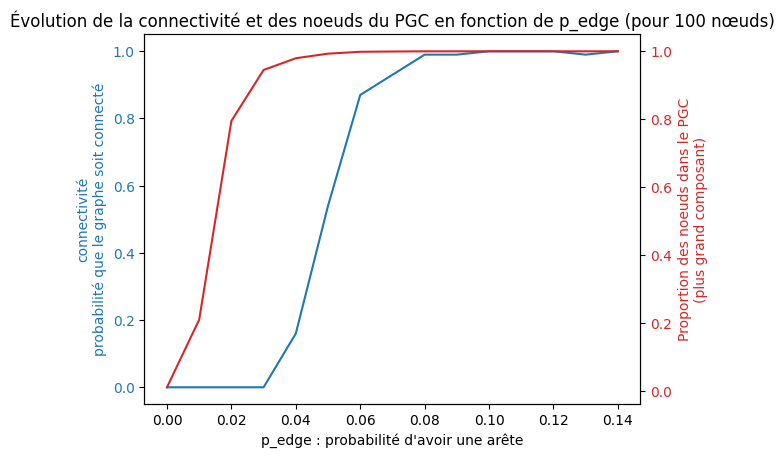

Connexion moyenne de 0.999% atteint à 1.10% pour 1000 nœuds


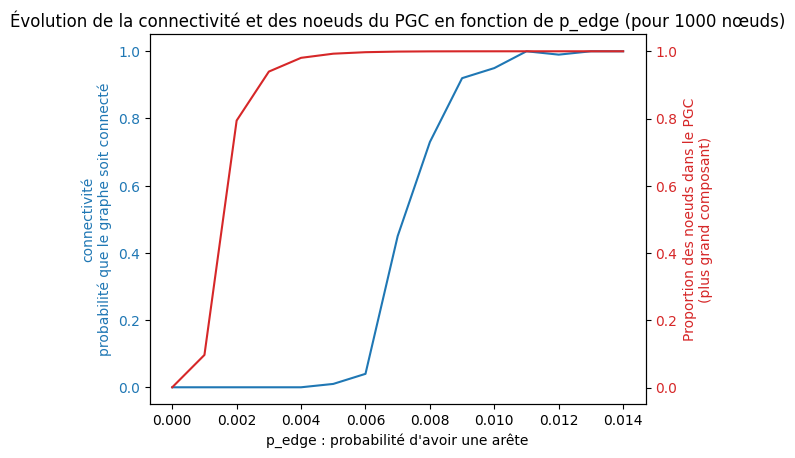

Connexion moyenne de 0.999% atteint à 0.12% pour 10000 nœuds


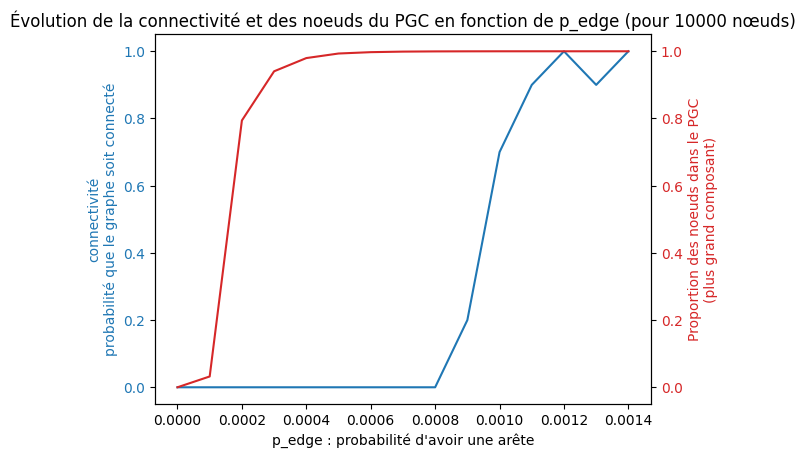

In [5]:
def q1(n_nodes, n_iterations, increment, prob_max, prob_min, connection_prob_target, draw_graph1=True):
    has_reached_target = False
    
    x = np.arange(prob_min, prob_max, increment)
    graph_connections = np.zeros(len(x))
    graph_largest_components = np.zeros(len(x))
    graph_degree_distributions = [[] for _ in range(len(x))]

    # For each edge probability
    for i, edge_prob in enumerate(x):
        sum, sum_largest_component = 0, 0
        
        # Calculate many graph connections
        for j in range(0, n_iterations):
            graph = nx.fast_gnp_random_graph(n_nodes, edge_prob)
            nodes_distribution = nx.degree_histogram(graph)
            
            if n_iterations == 1:
                graph_degree_distributions[i] = np.pad(nx.degree_histogram(graph), (0, max(0, n_nodes - len(nodes_distribution))), mode='constant').tolist()
            
            sum += nx.is_connected(graph)
            
            # Find the largest connected component
            largest_component = len(max(list(nx.connected_components(graph)), key=len))
            sum_largest_component += largest_component
            
        # Calculate average graph connection
        avg_connection = sum / n_iterations
        avg_largest_component = sum_largest_component / (n_iterations * n_nodes)
        
        # Check if the target has been reached
        if avg_connection >= connection_prob_target and not has_reached_target:
            if draw_graph1: print(f"Connexion moyenne de {connection_prob_target}% atteint à {edge_prob:.2%} pour {n_nodes} nœuds")
            has_reached_target = True
        
        graph_connections[i] = avg_connection
        graph_largest_components[i] = avg_largest_component
    
        # if (i/len(x)*100) % 10 == 0: print(f"{i/len(x):.0%}", end=" ")
    
    if n_iterations == 1: draw_ridgeplot(graph_degree_distributions, x)
    
    if not draw_graph1: return
    
    color = 'tab:blue'
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('p_edge : probabilité d\'avoir une arête')
    ax1.set_ylabel('connectivité\nprobabilité que le graphe soit connecté', color=color)
    ax1.set_title(f"Évolution de la connectivité et des noeuds du PGC en fonction de p_edge (pour {n_nodes} nœuds)")
    ax1.plot(x, graph_connections, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Proportion des noeuds dans le PGC\n(plus grand composant)', color=color)
    ax2.plot(x, graph_largest_components, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()
    
# q1(n_nodes=100, n_iterations=1, increment=.05, prob_max=1, prob_min=.0, connection_prob_target=.99, draw_graph1=False)
# q1(n_nodes=1000, n_iterations=1, increment=.05, prob_max=1, prob_min=.0, connection_prob_target=.99, draw_graph1=False)

q1(n_nodes=100, n_iterations=100, increment=.01, prob_min=.0, prob_max=.15, connection_prob_target=.999)
q1(n_nodes=1_000, n_iterations=100, increment=.001, prob_min=0, prob_max=.015,  connection_prob_target=.999)
q1(n_nodes=10_000, n_iterations=10, increment=.0001, prob_min=0, prob_max=.0015,  connection_prob_target=.999)


## Partie 2 - Simulation de jeu de graphes

### Faites une simulation de jeu de graphe simple (voir énoncé). Peut-on prédire la topologie du réseau ?  

Oui, on peut prédire la topologie du réseau. Cependant, l'énoncé n'étant pas assez clair, il y a plusieurs configurations possibles  
- Lorsqu'on crée une nouvelle arête, on peut ou pas mettre à jour la valeur du nœud cible → configuration réactive ou statique
- Lorsque plusieurs nœuds ont un timer à 0, on peut ajouter les arêtes successivement ou simultanément → configuration successive ou simultané


On a donc 4 configurations possibles
Remarque : Dans la grande majorité des cas, les réseaux seront cycliques.
- successive et réactive : ressemble à un réseau avec clusters, c'est-à-dire que certains nœuds ont beaucoup plus de voisins que d'autres.
- successive et statique : ressemble à un réseau en chaine, c'est-à-dire que chaque nœud à deux voisins (le premier nœud est le seul à n'en n'avoir qu'un).
- simultanée et réactive : ressemble à la 1ʳᵉ configuration.
- simultanée et statique : ressemble à un réseau en chaine, mais avec de petite branche.


Remarque : Les tests sont fait sur 500 nœuds au lieu de 10_000, et les calculs sur une moyenne de 100 itérations, pour épargner du temps de calcul.  

| configurations | réactive                                   | statique                                     |
|----------------|--------------------------------------------|----------------------------------------------|
| successive     | 35% connectés, ~3 taille moyenne de chemin | 39% connectés, ~135 taille moyenne de chemin |
| simultanée     | 32% connected, ~3 taille moyenne de chemin | 39% connectés, ~84 taille moyenne de chemin  |

On remarque que la configuration successive et réactive est la meilleure configuration, avec 42% de graphes connectés et une longueur moyenne de 21.86.

### Rendez le modèle plus réaliste (voir énoncé). Comment changera la topologie ? Change-t-elle entre chaque itération ? Quel est la distribution des valeurs ? Afficher quelques graphes.

On rend le modèle plus réaliste en introduisant la divergence. Avec une divergence de 0.5, quand on veut la valeur de son voisin, on obtient entre 50% et 150% de la véritable valeur.  
La première chose que l'on observe, c'est que tous les graphes ont la même topologie (celle de la chaine avec des petites branches).

Remarque : Cette fois, les tests ont été fait avec 300 itérations, pour avoir de meilleures moyennes.

| configurations | réactive                                    | statique                                    |
|----------------|---------------------------------------------|---------------------------------------------|
| successive     | 39% connectés, ~22 taille moyenne de chemin | 37% connectés ~30 taille moyenne de chemin  |
| simultanée     | 38% connectés, ~20 taille moyenne de chemin | 38% connectés, ~29 taille moyenne de chemin |




In [37]:
def graph_is_done(graph):
    """Check if the graph has a node with timer > 0"""
    for node in graph.nodes:
        if graph.nodes[node]['timer'] > 0: return False
    return True

def get_infos(graph, i, divergence):
    """Get the neighbors, the other nodes and the best node to connect to"""
    # Get the neighbors of the node
    neighbors = graph.neighbors(i)
    
    # Get all nodes except the specified node and its direct neighbors
    others = set(graph.nodes) - set([i] + list(neighbors))
    
    # If there are no other nodes, stop
    # This should never happen
    if others == set():
        draw_graph(graph)
        print("No other nodes")
        raise Exception("No other nodes")
        
    # Get other node with the highest value, with a random factor
    best_node = sorted(
        others,
        key=lambda x: graph.nodes[x]['value'] * random.uniform(1-divergence, 1+divergence),
        reverse=True
    )[0]
    return neighbors, others, best_node
    
def successive_edge_addition(graph, update_target_node, divergence):
    """Decrements each timer and adds edge successively"""
    for i, node in graph.nodes(data=True):
        # Skip if timer is 0 or lower, TODO : Regarder ce qui se passe en remplaçant <= par <
        if node['timer'] <= 0: continue
        
        # Decrement timer
        node['timer'] -= 1
        
        # Skip if timer is not 0
        if node['timer'] > 0: continue
        
        try:
            neighbors, others, best_node = get_infos(graph, i, divergence)
        except:
            break
    
        # Add new edge to the node with the highest value
        graph.add_edge(i, best_node)
        graph.nodes[i]['value'] = graph.nodes[best_node]['value'] + 1
        
        # Update the value of the target node if needed
        if update_target_node: graph.nodes[best_node]['value'] += 1
        
    return graph

def simultaneous_edge_addition(graph, update_target_node, divergence):
    """Decrements each timer and adds edge simultaneously"""
    for node in graph.nodes: graph.nodes[node]['timer'] -= 1
    
    # List of nodes (only ids) to update (where the time is 0)
    nodes_to_update = set(node for node in graph.nodes if graph.nodes[node]['timer'] == 0)
    # Future graph
    next_graph = graph.copy()
    
    
    # Update each node independently
    for i in nodes_to_update:
        
        try:
            neighbors, others, best_node = get_infos(graph, i, divergence)
        except:
            break
        
        # Update next graph
        next_graph.add_edge(i, best_node)
        next_graph.nodes[i]['value'] = graph.nodes[best_node]['value'] + 1
        if update_target_node: next_graph.nodes[best_node]['value'] += 1
        
    return next_graph
    
def perform(n_nodes, successive, update_target_node, divergence):
    """Performs the simulation game of the graph"""
    # Creating empty graph
    graph = nx.empty_graph(n_nodes,create_using=nx.Graph())

    # Adding n_nodes nodes, each node has a random timer
    for i in range(n_nodes):
        graph.add_node(i, timer=np.random.randint(0, n_nodes), value=0)
    
    # Performing node addition until all nodes have a timer of 0
    while not graph_is_done(graph):
        if successive:
            graph = successive_edge_addition(graph, update_target_node, divergence)
        else:
            graph = simultaneous_edge_addition(graph, update_target_node, divergence)
    
    return graph
        
def q2(n_iterations, n_nodes, successive=False, update_target_node=False, draw=False, divergence=0):
    sum_shortest_paths = 0
    nb_connected_graphs = 0
    sum_cycles = 0
    
    for i in range(n_iterations):
        graph = perform(n_nodes, successive, update_target_node, divergence)
        
        is_connected = nx.is_connected(graph)
        
        # Nombre de cycles
        cycles = nx.algorithms.cycles.cycle_basis(graph)
        sum_cycles += len(cycles)
        
        print("Connected" if is_connected else "Not connected")
        print("Cyclic" if len(cycles) else "Not cyclic")
        if is_connected:
            nb_connected_graphs += 1
            sum_shortest_paths += nx.average_shortest_path_length(graph)
            # print(f"Average shortest path length : {nx.average_shortest_path_length(graph)}")
        
        if draw: 
            draw_graph(graph)
            time.sleep(1)
            
    if n_iterations == 1: return
    
    # Calcul connectivité moyenne
    print(f"\nGraphes connectés: {nb_connected_graphs/n_iterations:.0%}")
    # Calcul nombre de cycles moyens
    print(f"Nombre de cycles moyens: {sum_cycles/n_iterations:.2f}")
    # Calcul longueur moyenne des graphes connectés
    print(f"Longueur moyenne des graphes connectés : {sum_shortest_paths/nb_connected_graphs:.2f}")

# q2(n_iterations=1, n_nodes=100, successive=True, update_target_node=True, draw=True)
# q2(n_iterations=1, n_nodes=200, successive=True, update_target_node=False, draw=True)
# q2(n_iterations=1, n_nodes=100, successive=False, update_target_node=True, draw=True)
# q2(n_iterations=1, n_nodes=200, successive=False, update_target_node=False, draw=True)
# 
# q2(n_iterations=100, n_nodes=500, successive=True, update_target_node=True, draw=False)
# q2(n_iterations=100, n_nodes=500, successive=True, update_target_node=False, draw=False)
# q2(n_iterations=100, n_nodes=500, successive=False, update_target_node=True, draw=False)
# q2(n_iterations=100, n_nodes=500, successive=False, update_target_node=False, draw=False)

# q2(n_iterations=1, n_nodes=200, successive=True, update_target_node=True, draw=True, divergence=0.5)
# q2(n_iterations=1, n_nodes=200, successive=True, update_target_node=False, draw=True, divergence=0.5)
# q2(n_iterations=1, n_nodes=200, successive=False, update_target_node=True, draw=True, divergence=0.5)
# q2(n_iterations=1, n_nodes=200, successive=False, update_target_node=False, draw=True, divergence=0.5)
# 
# q2(n_iterations=300, n_nodes=500, successive=True, update_target_node=True, divergence=0.5)
# q2(n_iterations=300, n_nodes=500, successive=True, update_target_node=False, divergence=0.5)
# q2(n_iterations=300, n_nodes=500, successive=False, update_target_node=True, divergence=0.5)
# q2(n_iterations=300, n_nodes=500, successive=False, update_target_node=False, divergence=0.5)
